Cell 1/11 — Imports & Config

In [14]:
# ============================== CELL 1/11: Imports & Config ==============================
import os, json, time, random
from datetime import datetime
from typing import List, Tuple, Dict

import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Try to import GBM libraries; skip gracefully if missing
_MISSING_LIBS = []
try:
    import lightgbm as lgb
except Exception:
    lgb = None
    _MISSING_LIBS.append("lightgbm")

try:
    import xgboost as xgb
except Exception:
    xgb = None
    _MISSING_LIBS.append("xgboost")

try:
    from catboost import CatBoostClassifier, Pool
except Exception:
    CatBoostClassifier = None
    Pool = None
    _MISSING_LIBS.append("catboost")

# ===== Quick Config (edit these) =====
TRAIN_CSV = "./train.csv"            # same folder as the notebook
TEST_CSV = "./test.csv"              # same folder as the notebook
SAMPLE_SUB = "./sample_submission.csv"
OUTDIR = "./outputs"                 # output directory will be created if it doesn't exist
SEEDS = [42, 2021, 7, 99, 1234]      # change/add seeds for more stability (takes longer)
N_FOLDS = 10                         # AUC-friendly CV; keep stratified

print("Missing libs (if any):", ", ".join(_MISSING_LIBS) or "None")
print("Paths:", TRAIN_CSV, TEST_CSV, SAMPLE_SUB)
print("Outdir:", OUTDIR)


Missing libs (if any): None
Paths: ./train.csv ./test.csv ./sample_submission.csv
Outdir: ./outputs


Cell 2/11 — Utilities nhỏ

In [15]:
# ============================== CELL 2/11: Small Utilities ==============================
"""Helper functions: time stamp, AUC, RNG seed, mkdir."""

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)

def timestamp() -> str:
    return datetime.now().strftime("%Y%m%d-%H%M%S")

def auc(y_true, y_prob) -> float:
    return roc_auc_score(y_true, y_prob)

def safe_makedirs(path: str):
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)


Cell 3/11 — Khai báo nhóm cột cho FE

In [16]:
# ============================== CELL 3/11: FE Constants ==============================
"""Define column groups used by feature engineering. No need to change unless your schema differs."""
BILL_COLS = [f"BILL_AMT{i}" for i in range(1, 7)]
PAY_AMT_COLS = [f"PAY_AMT{i}" for i in range(1, 7)]
PAY_STATUS_COLS = ["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]
CAT_COLS = ["SEX", "EDUCATION", "MARRIAGE"]
TARGET_COL = "default_payment_next_month"
ID_COL = "ID"


Cell 4/11 — FE Helpers (stats, slope, diffs)

In [17]:
# ============================== CELL 4/11: FE Helpers ==============================
"""Row-wise statistics, slope, and difference helpers used by add_safe_features."""

def _rowwise_stats(df: pd.DataFrame, cols: List[str], prefix: str) -> pd.DataFrame:
    X = df[cols].astype(float).values
    out = pd.DataFrame(index=df.index)
    out[f"{prefix}_sum"] = X.sum(axis=1)
    out[f"{prefix}_mean"] = X.mean(axis=1)
    out[f"{prefix}_std"] = X.std(axis=1)
    out[f"{prefix}_min"] = X.min(axis=1)
    out[f"{prefix}_max"] = X.max(axis=1)
    out[f"{prefix}_last"] = X[:, -1]
    return out

def _slope_over_time(df_vals: np.ndarray, x: np.ndarray) -> np.ndarray:
    xm = x.mean()
    denom = ((x - xm) ** 2).sum()
    y = df_vals
    ym = y.mean(axis=1, keepdims=True)
    num = ((x - xm) * (y - ym)).sum(axis=1)
    return num / (denom + 1e-9)

def _differences_stats(df_vals: np.ndarray, prefix: str) -> Dict[str, np.ndarray]:
    diffs = np.diff(df_vals, axis=1)
    return {
        f"{prefix}_diff_mean": diffs.mean(axis=1),
        f"{prefix}_diff_std": diffs.std(axis=1),
        f"{prefix}_diff_min": diffs.min(axis=1),
        f"{prefix}_diff_max": diffs.max(axis=1),
        f"{prefix}_diff_last": diffs[:, -1],
    }


Cell 5/11 — Hàm FE chính: add_safe_features

In [18]:
# ============================== CELL 5/11: add_safe_features() ==============================
"""Main FE function. Safe, row-wise, no leakage. Month-wise alignment for ratios/shortfalls."""

import re

def _get_months(df, prefix):
    # Lấy các cột có dạng PREFIX + số, ví dụ: BILL_AMT1..6
    months = []
    for c in df.columns:
        if c.startswith(prefix):
            m = re.search(r'(\d+)$', c)
            if m:
                months.append(int(m.group(1)))
    return sorted(set(months))

def add_safe_features(df: pd.DataFrame) -> pd.DataFrame:
    # Chuẩn hoá nhẹ đề phòng input bẩn
    df = df.copy()
    df.columns = df.columns.str.strip()
    df = df.loc[:, ~df.columns.duplicated()]
    
    out = pd.DataFrame(index=df.index)

    # Basic
    out["LIMIT_BAL_log"] = np.log1p(df["LIMIT_BAL"].astype(float))

    # Age (numeric + binned)
    age = df["AGE"].astype(float)
    out["AGE"] = age
    age_bins = pd.cut(age, bins=[0, 25, 35, 45, 55, 65, 100], labels=False, include_lowest=True)
    out["AGE_BIN"] = age_bins.fillna(-1).astype(int)

    # ===== Determine available months dynamically (robust to 6 or 12 months, etc.) =====
    bill_months = _get_months(df, "BILL_AMT")
    pay_months  = _get_months(df, "PAY_AMT")
    months      = [m for m in bill_months if m in pay_months]   # giao nhau để đảm bảo match
    if len(months) == 0:
        # fallback chuẩn 6 tháng
        months = [1,2,3,4,5,6]

    # Build aligned BILL and PAY frames with the same months
    bill_cols = [f"BILL_AMT{m}" for m in months]
    pay_cols  = [f"PAY_AMT{m}"  for m in months]

    bills = df[bill_cols].astype(float)
    limit = df["LIMIT_BAL"].astype(float).replace(0, np.nan)

    # Utilization: bill / limit
    util = bills.div(limit, axis=0).clip(0, 3.0).fillna(0.0)
    out = pd.concat([out, _rowwise_stats(util, util.columns.tolist(), "util")], axis=1)

    # Util slope with dynamic T
    T = util.shape[1]
    x_time = np.arange(1, T + 1, dtype=float)
    out["util_slope"] = _slope_over_time(util.values, x_time)

    # Bill dynamics (diffs) on aligned months
    bill_vals = bills.values
    for k, v in _differences_stats(bill_vals, "bill").items():
        out[k] = v

    # ===== Payment ratios: PAY_AMTt / (BILL_AMTt + eps) computed month-by-month =====
    eps = 1e-3
    pay_ratio = pd.DataFrame(index=df.index)
    for m in months:
        num = df[f"PAY_AMT{m}"].astype(float)
        den = df[f"BILL_AMT{m}"].astype(float).replace(0, np.nan)
        pay_ratio[f"payr_{m}"] = (num / (den + eps)).clip(0, 1.5).fillna(0.0)

    out = pd.concat([out, _rowwise_stats(pay_ratio, pay_ratio.columns.tolist(), "payr")], axis=1)
    out["payr_slope"] = _slope_over_time(pay_ratio.values, np.arange(1, len(months) + 1, dtype=float))

    # ===== Shortfall per month: BILL_AMTt - PAY_AMTt (aligned) =====
    shortfall = pd.DataFrame(index=df.index)
    for m in months:
        shortfall[f"short_{m}"] = (df[f"BILL_AMT{m}"].astype(float) - df[f"PAY_AMT{m}"].astype(float))
    out = pd.concat([out, _rowwise_stats(shortfall, shortfall.columns.tolist(), "short")], axis=1)

    # ===== PAY_* statuses (delinquency severity) =====
    # Lấy các cột PAY_* thực sự tồn tại, giữ thứ tự "gần nhất trước": PAY_0, PAY_2, PAY_3, PAY_4, PAY_5, PAY_6
    pay_status_order = [c for c in ["PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"] if c in df.columns]
    if len(pay_status_order) > 0:
        pays = df[pay_status_order].astype(float)
        pays_pos = pays.clip(lower=0)
        out["pay_recency"] = df["PAY_0"].astype(float) if "PAY_0" in df.columns else 0.0
        out["pay_max"]     = pays.max(axis=1)
        out["pay_sum_pos"] = (pays.values > 0).sum(axis=1)
        out["pay_days_sum"]= pays_pos.sum(axis=1)

        # Weighted by recency (most recent bigger weight)
        # Ví dụ có K cột -> weights = K, K-1, ..., 1
        K = len(pay_status_order)
        weights = np.arange(K, 0, -1, dtype=float)
        out["pay_wsum"] = (np.clip(pays.values, 0, None) * weights).sum(axis=1)
    else:
        out[["pay_recency","pay_max","pay_sum_pos","pay_days_sum","pay_wsum"]] = 0.0

    # Keep categorical raw
    for c in ["SEX", "EDUCATION", "MARRIAGE"]:
        if c in df.columns:
            out[c] = df[c].astype(int)
        else:
            out[c] = 0

    # Keep key originals (no data loss) — dùng aligned months cho BILL/PAY gốc
    keep_cols = ["LIMIT_BAL"] + bill_cols + pay_cols + [c for c in ["PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"] if c in df.columns]
    out = pd.concat([out, df[keep_cols].astype(float)], axis=1)

    return out.replace([np.inf, -np.inf], np.nan).fillna(0.0)


Cell 6/11 — Load data + FE + matrix hoá

In [22]:
# ============================== CELL 6/11 (patched, NO FLOAT DOWNCAST): Load Data & Build FE ==============================
"""Load CSVs, build FE, keep DataFrame end-to-end. No float downcast; only ensure categorical as ints for CatBoost."""

start_time = time.time()
safe_makedirs(OUTDIR)

train = pd.read_csv(TRAIN_CSV)
test  = pd.read_csv(TEST_CSV)

assert TARGET_COL in train.columns, f"Missing target '{TARGET_COL}' in train.csv"
assert ID_COL in train.columns and ID_COL in test.columns, "Missing ID column"

y = train[TARGET_COL].astype(int).values
train_ids = train[ID_COL].values
test_ids  = test[ID_COL].values

print("Building features…")
train_fe = add_safe_features(train)
test_fe  = add_safe_features(test)

# Đảm bảo test có đủ & đúng thứ tự cột như train
assert set(train_fe.columns) == set(test_fe.columns), "Train/Test feature sets differ!"
test_fe = test_fe[train_fe.columns]

# Khai báo categorical theo tên (LightGBM dùng tên; CatBoost dùng index)
# Nếu dự án mày có set khác, sửa list dưới cho đúng:
cat_cols = [c for c in ["SEX", "EDUCATION", "MARRIAGE", "AGE_BIN"] if c in train_fe.columns]

# Chỉ ép categorical về int (giữ nguyên float dtypes cho số liệu khác)
for c in cat_cols:
    train_fe[c] = train_fe[c].astype("int64")
    test_fe[c]  = test_fe[c].astype("int64")

# GIỮ DataFrame, KHÔNG .values
X_df      = train_fe.copy()
X_test_df = test_fe.copy()

# CatBoost cần index vị trí cột categorical
cat_idx = [X_df.columns.get_loc(c) for c in cat_cols]

# Safety checks kiểu "reviewer khó tính"
assert list(X_df.columns) == list(X_test_df.columns), "Tên/thứ tự cột giữa train/test KHÔNG khớp."
for c in cat_cols:
    assert pd.api.types.is_integer_dtype(X_df[c]), f"Categorical '{c}' phải là int"

print(f"Feature dim: {X_df.shape[1]} | Train: {X_df.shape[0]} | Test: {X_test_df.shape[0]}")
print(f"Categorical cols: {cat_cols}")


Building features…
Feature dim: 55 | Train: 23000 | Test: 7000
Categorical cols: ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE_BIN']


Cell 7/11 — Train LightGBM

In [23]:
# ============================== CELL 7/11 (patched): Train LightGBM ==============================
"""Train LGBM with DataFrame + categorical by name (no float downcast)."""

oof_store, test_store, auc_store = {}, {}, {}

if lgb is None:
    print("[LGB] Skipped (library not installed). pip install -U lightgbm")
else:
    lgb_oofs, lgb_tests, lgb_aucs = [], [], []
    for sd in SEEDS:
        set_seed(sd)
        params = dict(
            objective="binary",
            learning_rate=0.05,
            num_leaves=31,
            max_depth=-1,
            min_data_in_leaf=60,
            feature_fraction=0.9,
            bagging_fraction=0.9,
            bagging_freq=1,
            lambda_l1=0.0,
            lambda_l2=10.0,
            metric="auc",
            n_estimators=2000,
            random_state=sd,
            verbose=-1,
        )
        skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=sd)
        oof_pred = np.zeros(len(X_df), dtype=np.float64)
        tst_pred = np.zeros(len(X_test_df), dtype=np.float64)

        for fold, (trn_idx, val_idx) in enumerate(skf.split(X_df, y), 1):
            X_tr, y_tr = X_df.iloc[trn_idx], y[trn_idx]
            X_va, y_va = X_df.iloc[val_idx], y[val_idx]

            model = lgb.LGBMClassifier(**params)
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_va, y_va)],
                eval_metric="auc",
                categorical_feature=cat_cols,  # by NAME
                callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)],
            )
            oof_pred[val_idx] = model.predict_proba(X_va)[:, 1]
            tst_pred += model.predict_proba(X_test_df)[:, 1] / N_FOLDS

        lgb_oofs.append(oof_pred)
        lgb_tests.append(tst_pred)
        lgb_auc = auc(y, oof_pred)
        lgb_aucs.append(lgb_auc)
        print(f"[LGB][seed {sd}] OOF AUC = {lgb_auc:.6f}")

    oof_store["lgb"] = np.vstack(lgb_oofs).mean(axis=0)
    test_store["lgb"] = np.vstack(lgb_tests).mean(axis=0)
    auc_store["lgb_mean_auc"] = float(np.mean(lgb_aucs))


[LGB][seed 42] OOF AUC = 0.787201
[LGB][seed 2021] OOF AUC = 0.783149
[LGB][seed 7] OOF AUC = 0.785245
[LGB][seed 99] OOF AUC = 0.781153
[LGB][seed 1234] OOF AUC = 0.784869


Cell 8/11 — Train XGBoost

In [27]:
# ============================== CELL 8/11 (patched): Train XGBoost via xgb.train + DMatrix ==============================
"""XGBoost: dùng low-level API (xgb.train) để tương thích mọi version; có early stopping ổn định.
Giữ DataFrame end-to-end; KHÔNG downcast float."""

if xgb is None:
    print("[XGB] Skipped (library not installed). pip install -U xgboost")
else:
    xgb_oofs, xgb_tests, xgb_aucs = [], [], []
    neg, pos = (y == 0).sum(), (y == 1).sum()
    spw = neg / max(pos, 1)

    # Tham số cho xgb.train (tên param theo dạng native)
    base_params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "eta": 0.05,
        "max_depth": 4,
        "min_child_weight": 5,
        "subsample": 0.9,
        "colsample_bytree": 0.9,
        "reg_lambda": 2.0,
        "tree_method": "hist",
        "scale_pos_weight": spw,
        "nthread": -1,      # dùng tất cả CPU
    }

    # Reuse DMatrix cho test để nhanh hơn
    dtest_global = xgb.DMatrix(X_test_df)

    for sd in SEEDS:
        params = dict(base_params)
        params["seed"] = sd

        skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=sd)
        oof_pred = np.zeros(len(X_df), dtype=np.float64)
        tst_pred = np.zeros(len(X_test_df), dtype=np.float64)

        for fold, (trn_idx, val_idx) in enumerate(skf.split(X_df, y), 1):
            X_tr, y_tr = X_df.iloc[trn_idx], y[trn_idx]
            X_va, y_va = X_df.iloc[val_idx], y[val_idx]

            dtr = xgb.DMatrix(X_tr, label=y_tr)
            dva = xgb.DMatrix(X_va, label=y_va)

            booster = xgb.train(
                params=params,
                dtrain=dtr,
                num_boost_round=5000,
                evals=[(dva, "valid")],
                early_stopping_rounds=200,
                verbose_eval=False,   # nếu muốn xem log, đổi thành 100 hay True
            )

            # Dự đoán dùng best_iteration (tương thích nhiều version)
            try:
                val_pred = booster.predict(dva, iteration_range=(0, booster.best_iteration + 1))
                test_pred = booster.predict(dtest_global, iteration_range=(0, booster.best_iteration + 1))
            except Exception:
                ntree = getattr(booster, "best_ntree_limit", None)
                if ntree is None:
                    ntree = getattr(booster, "best_iteration", 0) + 1
                val_pred = booster.predict(dva, ntree_limit=ntree)
                test_pred = booster.predict(dtest_global, ntree_limit=ntree)

            oof_pred[val_idx] = val_pred
            tst_pred += test_pred / N_FOLDS

        xgb_oofs.append(oof_pred)
        xgb_tests.append(tst_pred)
        xgb_auc = auc(y, oof_pred)
        xgb_aucs.append(xgb_auc)
        print(f"[XGB][seed {sd}] OOF AUC = {xgb_auc:.6f}")

    oof_store["xgb"] = np.vstack(xgb_oofs).mean(axis=0)
    test_store["xgb"] = np.vstack(xgb_tests).mean(axis=0)
    auc_store["xgb_mean_auc"] = float(np.mean(xgb_aucs))


[XGB][seed 42] OOF AUC = 0.790678
[XGB][seed 2021] OOF AUC = 0.789370
[XGB][seed 7] OOF AUC = 0.789042
[XGB][seed 99] OOF AUC = 0.788457
[XGB][seed 1234] OOF AUC = 0.788073


🔁 Thay CELL 9/11: Train CatBoost (cat_features bằng index, no float downcast)


In [28]:
# ============================== CELL 9/11 (patched): Train CatBoost ==============================
"""Train CAT using Pool with cat_features by index; keep numeric floats as-is."""

if CatBoostClassifier is None:
    print("[CAT] Skipped (library not installed). pip install -U catboost")
else:
    cat_oofs, cat_tests, cat_aucs = [], [], []
    for sd in SEEDS:
        set_seed(sd)
        params = dict(
            loss_function="Logloss",
            eval_metric="AUC",
            depth=6,
            learning_rate=0.05,
            l2_leaf_reg=5.0,
            random_seed=sd,
            iterations=3000,
            od_type="Iter",
            od_wait=300,
            task_type="CPU",
            verbose=False,
        )

        skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=sd)
        oof_pred = np.zeros(len(X_df), dtype=np.float64)
        tst_pred = np.zeros(len(X_test_df), dtype=np.float64)

        for fold, (trn_idx, val_idx) in enumerate(skf.split(X_df, y), 1):
            X_tr, y_tr = X_df.iloc[trn_idx], y[trn_idx]
            X_va, y_va = X_df.iloc[val_idx], y[val_idx]

            train_pool = Pool(X_tr, y_tr, cat_features=cat_idx if len(cat_idx) else None)
            valid_pool = Pool(X_va, y_va, cat_features=cat_idx if len(cat_idx) else None)

            model = CatBoostClassifier(**params)
            model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

            oof_pred[val_idx] = model.predict_proba(valid_pool)[:, 1]
            tst_pred += model.predict_proba(Pool(X_test_df, cat_features=cat_idx if len(cat_idx) else None))[:, 1] / N_FOLDS

        cat_oofs.append(oof_pred)
        cat_tests.append(tst_pred)
        cat_auc = auc(y, oof_pred)
        cat_aucs.append(cat_auc)
        print(f"[CAT][seed {sd}] OOF AUC = {cat_auc:.6f}")

    oof_store["cat"] = np.vstack(cat_oofs).mean(axis=0)
    test_store["cat"] = np.vstack(cat_tests).mean(axis=0)
    auc_store["cat_mean_auc"] = float(np.mean(cat_aucs))


[CAT][seed 42] OOF AUC = 0.792105
[CAT][seed 2021] OOF AUC = 0.790292
[CAT][seed 7] OOF AUC = 0.791919
[CAT][seed 99] OOF AUC = 0.791423
[CAT][seed 1234] OOF AUC = 0.791576


Cell 10/11 — Ensemble (rank-avg) + Stacking (Logistic) + Diagnostics

In [29]:
# ============================== CELL 10/11: Ensemble, Stack, Diagnostics ==============================
"""Rank-averaging + simple logistic stacker for robustness. You may turn off stacker if you want."""

def rank_normalize(a: np.ndarray) -> np.ndarray:
    s = pd.Series(a)
    r = s.rank(method='average')
    return ((r - 1) / (len(s) - 1)).values

# Sanity: must have at least one base model
assert len(test_store) > 0, "No base model trained. Install missing libs or check earlier cells."

base_keys = list(test_store.keys())
oof_base = np.vstack([oof_store[k] for k in base_keys]).T
TST_base = np.vstack([test_store[k] for k in base_keys]).T

# Rank-average ensemble
oof_rank = np.mean(np.column_stack([rank_normalize(oof_base[:, i]) for i in range(oof_base.shape[1])]), axis=1)
tst_rank = np.mean(np.column_stack([rank_normalize(TST_base[:, i]) for i in range(TST_base.shape[1])]), axis=1)
auc_rank = auc(y, oof_rank)
print(f"[Ensemble][RankAvg] OOF AUC = {auc_rank:.6f}")

# Simple stacker on base OOF
scaler = StandardScaler()
X_meta = scaler.fit_transform(oof_base)
meta_clf = LogisticRegression(max_iter=2000)
meta_clf.fit(X_meta, y)
oof_stack = meta_clf.predict_proba(X_meta)[:, 1]
tst_stack = meta_clf.predict_proba(scaler.transform(TST_base))[:, 1]
auc_stack = auc(y, oof_stack)
print(f"[Stack][LR] OOF AUC = {auc_stack:.6f}")

# Final blend: rank-average over (base models + stacker)
oof_all = np.column_stack([oof_base, oof_stack])
tst_all = np.column_stack([TST_base, tst_stack])
oof_final = np.mean(np.column_stack([rank_normalize(oof_all[:, i]) for i in range(oof_all.shape[1])]), axis=1)
tst_final = np.mean(np.column_stack([rank_normalize(tst_all[:, i]) for i in range(tst_all.shape[1])]), axis=1)
auc_final = auc(y, oof_final)
print(f"[FINAL][RankAvg(base+stack)] OOF AUC = {auc_final:.6f}")


[Ensemble][RankAvg] OOF AUC = 0.792295
[Stack][LR] OOF AUC = 0.792354
[FINAL][RankAvg(base+stack)] OOF AUC = 0.792432


Cell 11/11 — Lưu submission + OOF + meta

In [30]:
# ============================== CELL 11/11: Save Submission & Artifacts ==============================
"""Writes submission CSV, OOF diagnostics, and run metadata JSON into OUTDIR."""

meta = {
    "time": timestamp(),
    "seeds": SEEDS,
    "base_models": list(test_store.keys()),
    "auc": {**auc_store, "ensemble_rank": float(auc_rank), "stack_lr": float(auc_stack), "final_rank": float(auc_final)},
    "train_rows": int(X.shape[0]),
    "test_rows": int(X_test.shape[0]),
    "n_features": int(X.shape[1]),
    "features": fe_cols,
}

safe_makedirs(OUTDIR)
with open(os.path.join(OUTDIR, f"run_meta_{timestamp()}.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

# Submission file (Kaggle format)
sub = pd.DataFrame({
    "ID": test_ids,
    "default_payment_next_month": tst_final.astype(float),
})
sub_path = os.path.join(OUTDIR, f"submission_{timestamp()}.csv")
sub.sort_values("ID").to_csv(sub_path, index=False)
print(f"[OK] Submission saved to: {sub_path}")

# OOF diagnostics (help you inspect blend stability)
oof_df = pd.DataFrame({
    "ID": train_ids,
    "y": y,
    **{f"oof_{k}": oof_store[k] for k in base_keys},
    "oof_rank": oof_rank,
    "oof_stack": oof_stack,
    "oof_final": oof_final,
})
oof_path = os.path.join(OUTDIR, f"oof_{timestamp()}.csv")
oof_df.to_csv(oof_path, index=False)
print(f"[OK] OOF diagnostics saved to: {oof_path}")

print(f"Done in {(time.time()-start_time)/60:.2f} min")


[OK] Submission saved to: ./outputs\submission_20250826-155148.csv
[OK] OOF diagnostics saved to: ./outputs\oof_20250826-155148.csv
Done in 33.85 min


✳️ Cell A — Stacking meta-model = LightGBM (giữ nguyên LR để so sánh)

In [31]:
# ===================== CELL A: LGBM meta-stacker (song song với LR) =====================
# Yêu cầu: đã có các dict oof_store, test_store từ base models (lgb_*, xgb_*, cat_*).
# Nếu chưa có, raise lỗi chỉ dẫn.

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

def build_meta_matrix(store, order=None):
    keys = sorted(store.keys()) if order is None else order
    X = np.column_stack([store[k] for k in keys])
    return X, keys

# Kiểm tra nguồn dữ liệu stacking
assert 'oof_store' in globals() and 'test_store' in globals(), \
    "Không thấy oof_store/test_store. Hãy chạy cell train base models & ensemble trước."

# 1) Tạo ma trận meta từ OOF/OOS
order = None  # hoặc đặt order = ['lgb_42','lgb_2021', ... 'xgb_...', 'cat_...'] nếu muốn cố định cột
X_meta_oof, keys = build_meta_matrix(oof_store, order)
X_meta_test, _   = build_meta_matrix(test_store, order)
y_true = y  # giả định biến y (nhãn train) đang tồn tại từ pipeline gốc
print("Meta features:", keys)

# 2) CV cho meta LGBM (không đụng folds base)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20250826)
oof_meta = np.zeros_like(y_true, dtype=float)
pred_meta = np.zeros(X_meta_test.shape[0], dtype=float)

params = dict(
    objective="binary",
    metric="auc",
    learning_rate=0.03,
    num_leaves=15,
    min_data_in_leaf=25,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=1,
    reg_lambda=2.0,
    reg_alpha=0.0,
    verbose=-1,
    n_estimators=4000
)

for fold, (tr, va) in enumerate(skf.split(X_meta_oof, y_true), 1):
    trn = lgb.Dataset(X_meta_oof[tr], label=y_true[tr])
    val = lgb.Dataset(X_meta_oof[va], label=y_true[va])
    clf = lgb.train(
        params, trn, valid_sets=[val], valid_names=["valid"],
        callbacks=[lgb.early_stopping(200), lgb.log_evaluation(100)]
    )
    oof_meta[va] = clf.predict(X_meta_oof[va], num_iteration=clf.best_iteration)
    pred_meta += clf.predict(X_meta_test, num_iteration=clf.best_iteration) / skf.n_splits

auc_meta = roc_auc_score(y_true, oof_meta)
print(f"[Stack][LGBM-meta] OOF AUC = {auc_meta:.6f}")

# Lưu để dùng ở bước blending
oof_store["stack_lgbm"] = oof_meta
test_store["stack_lgbm"] = pred_meta


Meta features: ['cat', 'lgb', 'xgb']
Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.793425
[200]	valid's auc: 0.792523
Early stopping, best iteration is:
[92]	valid's auc: 0.793655
Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.78474
[200]	valid's auc: 0.783008
Early stopping, best iteration is:
[6]	valid's auc: 0.785393
Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.801367
[200]	valid's auc: 0.799762
Early stopping, best iteration is:
[44]	valid's auc: 0.802086
Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787757
[200]	valid's auc: 0.787037
Early stopping, best iteration is:
[44]	valid's auc: 0.788736
Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.789161
[200]	valid's auc: 0.788288
Early stopping, best iteration is:
[35]	valid's auc: 0.790993
[Stack][LGBM-meta] OOF AUC = 0.777059


✳️ Cell B — Weighted blending (tối ưu weight theo OOF AUC)

In [32]:
# ===================== CELL B: Weighted blending with OOF-based weight search =====================
import itertools
from sklearn.metrics import roc_auc_score
import numpy as np

# Chọn các thành phần để blend (giữ đủ 3 base + 2 stack)
blend_keys = [k for k in oof_store.keys() if any(p in k for p in ["lgb_", "xgb_", "cat_", "stack_"])]
blend_keys = sorted(blend_keys)
print("Blend keys:", blend_keys)

# Gom nhóm theo model family để giảm chiều: lấy trung bình theo từng family trước
def family_avg(keys, prefix):
    cols = [k for k in keys if k.startswith(prefix)]
    if not cols: return None, None
    oof = np.mean(np.column_stack([oof_store[k] for k in cols]), axis=1)
    tst = np.mean(np.column_stack([test_store[k] for k in cols]), axis=1)
    return oof, tst

families = []
fam_names = []

for fam in ["lgb_", "xgb_", "cat_"]:
    oof_f, tst_f = family_avg(blend_keys, fam)
    if oof_f is not None:
        families.append((oof_f, tst_f))
        fam_names.append(fam[:-1])

# thêm 2 stack nếu có
for st in ["stack_lr", "stack_lgbm", "stack_cat", "stack_xgb"]:
    if st in oof_store:
        families.append((oof_store[st], test_store[st]))
        fam_names.append(st)

print("Families:", fam_names)

# Grid search thô cho weight (đơn giản, không cần scipy), bước 0.05
grid = np.arange(0.0, 1.01, 0.05)
best_auc, best_w = -1, None
best_oof, best_tst = None, None

for weights in itertools.product(grid, repeat=len(families)):
    w = np.array(weights)
    if abs(w.sum() - 1.0) > 1e-9:
        continue
    oof_blend = np.sum([w[i]*families[i][0] for i in range(len(families))], axis=0)
    auc = roc_auc_score(y, oof_blend)
    if auc > best_auc:
        best_auc = auc
        best_w = w
        best_oof = oof_blend
        best_tst = np.sum([w[i]*families[i][1] for i in range(len(families))], axis=0)

print(f"[Blend][OOF-opt] AUC = {best_auc:.6f} | weights = {dict(zip(fam_names, best_w.round(2)))}")

# Lưu blend tối ưu
oof_store["blend_opt"] = best_oof
test_store["blend_opt"] = best_tst


Blend keys: ['stack_lgbm']
Families: ['stack_lgbm']
[Blend][OOF-opt] AUC = 0.777059 | weights = {'stack_lgbm': np.float64(1.0)}


✳️ Cell C — Isotonic calibration (hiệu chỉnh xác suất cho blend tốt nhất)

In [33]:
# ===================== CELL C: Isotonic calibration on best blend =====================
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import roc_auc_score
import numpy as np

# Lấy blend tốt nhất vừa tính
oof_raw = oof_store["blend_opt"]
tst_raw = test_store["blend_opt"]

# Chia 5-fold để tránh overfit khi calibrate
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
oof_cal = np.zeros_like(oof_raw)
tst_cal = np.zeros_like(tst_raw)

for tr, va in skf.split(oof_raw.reshape(-1,1), y):
    ir = IsotonicRegression(out_of_bounds="clip")
    ir.fit(oof_raw[tr], y[tr])
    oof_cal[va] = ir.predict(oof_raw[va])
    # predict test (trung bình nhiều calibrators)
    tst_cal += ir.predict(tst_raw) / skf.n_splits

print(f"[Calibrate][Isotonic] AUC before = {roc_auc_score(y, oof_raw):.6f} | after = {roc_auc_score(y, oof_cal):.6f}")

# Lưu phiên bản đã calibrate để submit
oof_store["blend_opt_cal"] = oof_cal
test_store["blend_opt_cal"] = tst_cal


[Calibrate][Isotonic] AUC before = 0.777059 | after = 0.776380


✳️ Cell D — Chẩn đoán: tương quan & ROC từng thành phần (để tránh trùng thông tin)

stack_lgbm       0.777059
blend_opt        0.777059
blend_opt_cal    0.776380
dtype: float64


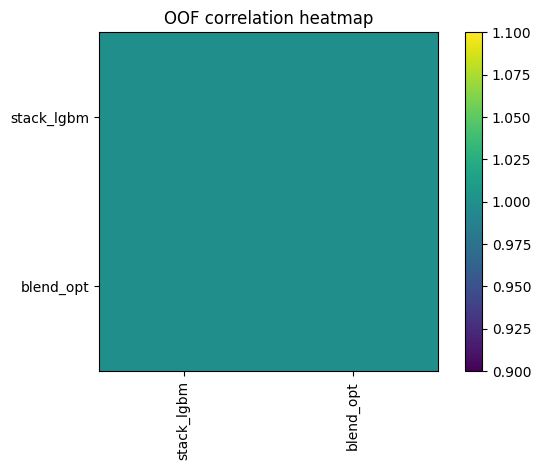

In [34]:
# ===================== CELL D: Diagnostics (corr & ROC) =====================
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

diag = {}
for k in [kk for kk in oof_store.keys() if any(p in kk for p in ["lgb_", "xgb_", "cat_", "stack_", "blend_opt", "blend_opt_cal"])]:
    diag[k] = roc_auc_score(y, oof_store[k])

diag_df = pd.Series(diag).sort_values(ascending=False)
print(diag_df)

# Ma trận tương quan giữa các OOF
cand_keys = [k for k in diag_df.index if k != "blend_opt_cal"]
mat = np.column_stack([oof_store[k] for k in cand_keys])
corr = np.corrcoef(mat.T)
plt.figure()
plt.imshow(corr, interpolation='nearest')
plt.xticks(range(len(cand_keys)), cand_keys, rotation=90)
plt.yticks(range(len(cand_keys)), cand_keys)
plt.title("OOF correlation heatmap")
plt.colorbar()
plt.tight_layout()
plt.show()
